In [3]:
from stable_baselines3 import PPO
import os
os.chdir('/home/ml/Projects/retro-rl')
import sys
sys.path.append("../../")
sys.path.append("../")
import tempfile
import time
import seaborn as sns
import numpy as np
import re
import pandas as pd

from helpers.saving_utils import get_exp_params, GoogleDriveCheckpointer

# Needed for loading pickle
from MortalKombat2.wrappers import FrameskipWrapper, MaxEpLenWrapper
from stable_baselines3.common.atari_wrappers import WarpFrame
from stable_baselines3.common.monitor import Monitor
import MortalKombat2

sns.set_style("dark", {'axes.grid' : True})

project_name = "miki.pacman/MK2"
google_drive_checkpoints_path = "MK2/saves"
exp_ids = ["MK-20"]

params = get_exp_params(exp_ids[0], project_name)

In [4]:
def get_learning_curve_for_exp(exp_id, env, num_eval_per_checkpoint):
    with tempfile.TemporaryDirectory(dir="/tmp") as temp:
        checkpointer = GoogleDriveCheckpointer(project_experiments_path=google_drive_checkpoints_path, exp_id=exp_id)
        checkpoints_list = checkpointer.get_list_of_checkpoints()
        checkpointer.download_checkpoints(checkpoints_list, temp)

        x, y = [], []
        for root, _, files in os.walk(temp):
            d = {int(re.findall(r"\d+", file)[-1]): file for file in files}
            for xdd in sorted(d.keys())[::-1]:
                r = []
                for _ in range(num_eval_per_checkpoint):
                    file = d[xdd]
                    model = PPO.load(os.path.join(root, file))
                    done = False
                    obs = env.reset()
                    while not done:
                        obs, _, done, info = env.step(model.predict(obs)[0])
                    r.append(info["episode"]["r"])

                y.append(np.mean(r))
                x.append(xdd)
            
    return x, y

In [ ]:
df = pd.DataFrame()

for exp_id in exp_ids:
    for diff in list(params["difficulties"]):
        params.update({"difficulties": [diff]})
        env = params["env_function"](params, train=True)
        x, y = get_learning_curve_for_exp(exp_id, env, num_eval_per_checkpoint=16)
        df = df.append(pd.DataFrame({
            "num_timesteps": x, 
            "rew": y, 
            "difficulty": [diff] * len(x),
            "exp_id": [exp_id] * len(x),
        }), ignore_index=True)
        env.close()

<AxesSubplot:xlabel='num_timesteps', ylabel='rew'>

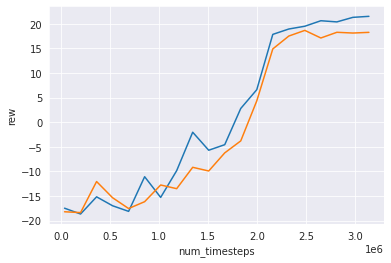

In [19]:
sns.lineplot(data=df[df.exp_id == exp_ids[0]], x="num_timesteps", y="rew", hue="state_versions", legend=False)